# Neural ODE - Milestone 1: Fixed Point Regression on Make Moons

In this notebook, we train a Neural ODE to transport points from the `make_moons` distribution (at $t=0$) to linearly separated clusters (at $t=1$).

This is treated as a **Fixed Point Regression** problem where we minimize $||x(1) - x_{target}||^2$.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add src to path
sys.path.append(os.path.join(os.getcwd(), '../src'))

from models.vector_fields import VectorField
from models.neural_odes import NeuralODE
from utils.viz import plot_trajectories, plot_vector_field

%matplotlib inline

## 1. Load Data

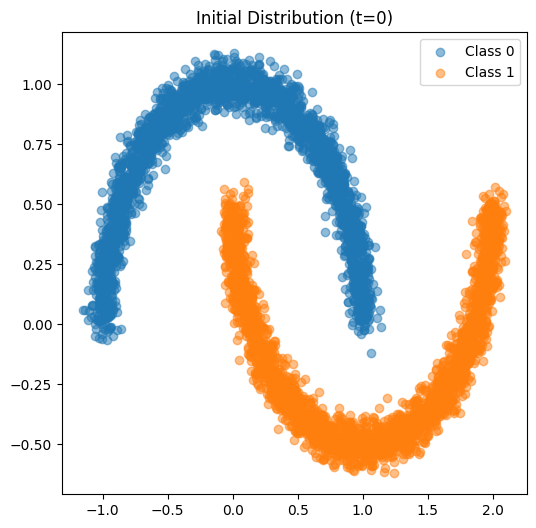

In [2]:
# Generate make_moons data
n_samples = 5000
noise = 0.05
X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)

# Convert to tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Visualize initial distribution
plt.figure(figsize=(6, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], label='Class 0', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], label='Class 1', alpha=0.5)
plt.title("Initial Distribution (t=0)")
plt.legend()
plt.show()

## 2. Define Targets

We define arbitrary target states for $t=1$.
- Class 0 -> Cluster around $[-2, 0]$
- Class 1 -> Cluster around $[2, 0]$

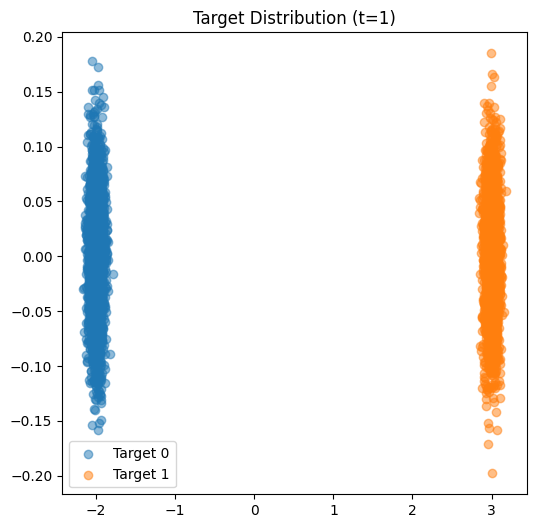

In [10]:
# Define target means
target_means = torch.tensor([[-2.0, 0.0], [3.0, 0.0]])

# Generate targets with some variance
target_noise = 0.05
targets = target_means[y_tensor] + torch.randn_like(X_tensor) * target_noise

# Visualize targets
plt.figure(figsize=(6, 6))
plt.scatter(targets[y==0, 0], targets[y==0, 1], label='Target 0', alpha=0.5)
plt.scatter(targets[y==1, 0], targets[y==1, 1], label='Target 1', alpha=0.5)
plt.title("Target Distribution (t=1)")
plt.legend()
plt.show()

## 3. Initialize Model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

features = 2
hidden_dims = [64, 64, 64]
time_embed_dim = 16

vf = VectorField(features=features, hidden_dims=hidden_dims, time_embed_dim=time_embed_dim)
model = NeuralODE(vector_field=vf, solver='rk4').to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

Using device: cuda


## 4. Training Loop

Epoch 50/500, Loss: 0.026911
Epoch 100/500, Loss: 0.010217
Epoch 150/500, Loss: 0.005752
Epoch 200/500, Loss: 0.004118
Epoch 250/500, Loss: 0.003460
Epoch 300/500, Loss: 0.003197
Epoch 350/500, Loss: 0.003071
Epoch 400/500, Loss: 0.002910
Epoch 450/500, Loss: 0.002902
Epoch 500/500, Loss: 0.002849


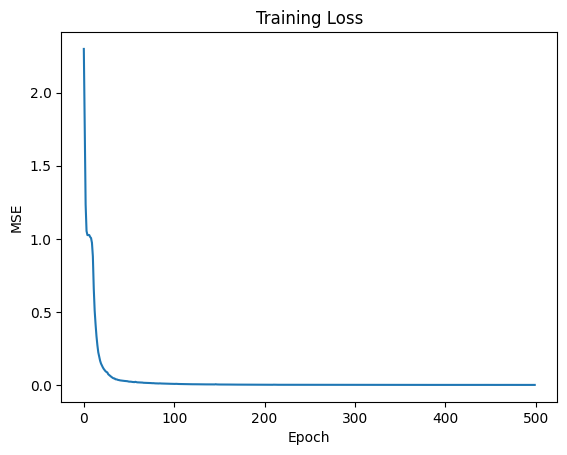

In [ ]:
epochs = 500
batch_size = 256
t_span = torch.tensor([0., 1.]).to(device)

dataset = torch.utils.data.TensorDataset(X_tensor, targets)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []

for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, batch_target in dataloader:
        batch_x = batch_x.to(device)
        batch_target = batch_target.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass: integrate from t=0 to t=1
        # model returns (len(t_span), batch, features)
        out = model(batch_x, t_span)
        
        # Get state at t=1 (last time point)
        x_1 = out[-1]
        
        # MSE Loss TODO: change to negative log likelyhood loss?
        loss = nn.MSELoss()(x_1, batch_target)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

## 5. Visualization

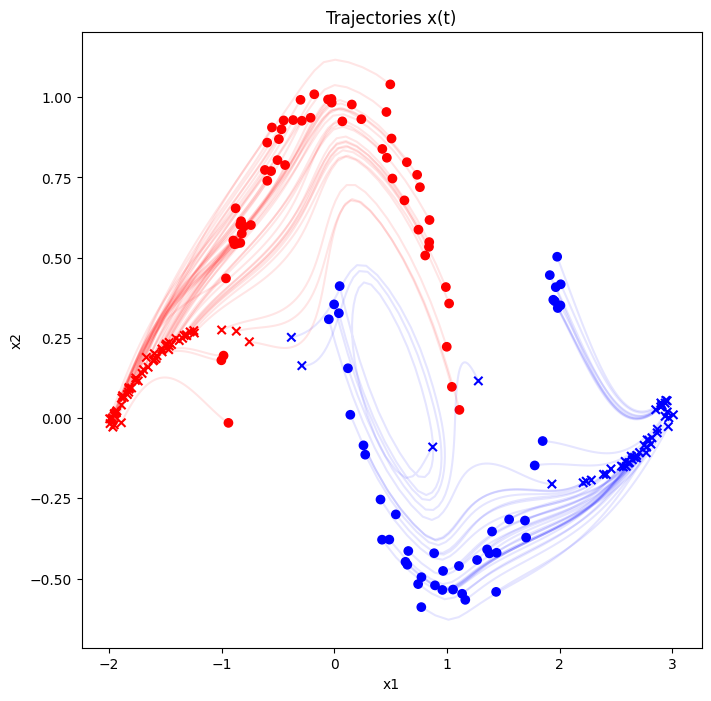

In [13]:
# Plot Trajectories
subset_indices = np.random.choice(len(X), 100, replace=False)
x0_subset = X_tensor[subset_indices].to(device)
y_subset = y_tensor[subset_indices]

t_eval = torch.linspace(0, 1, 50).to(device)

plot_trajectories(model, x0_subset, t_eval, labels=y_subset)

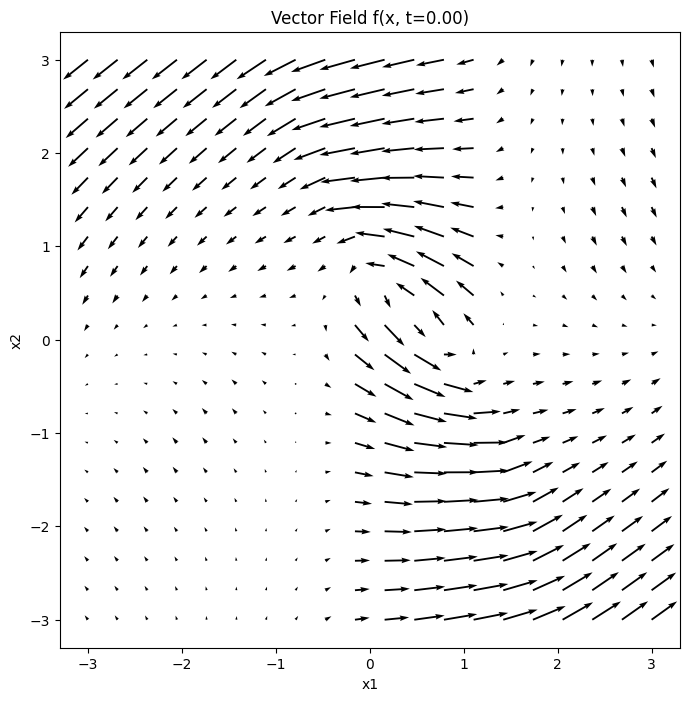

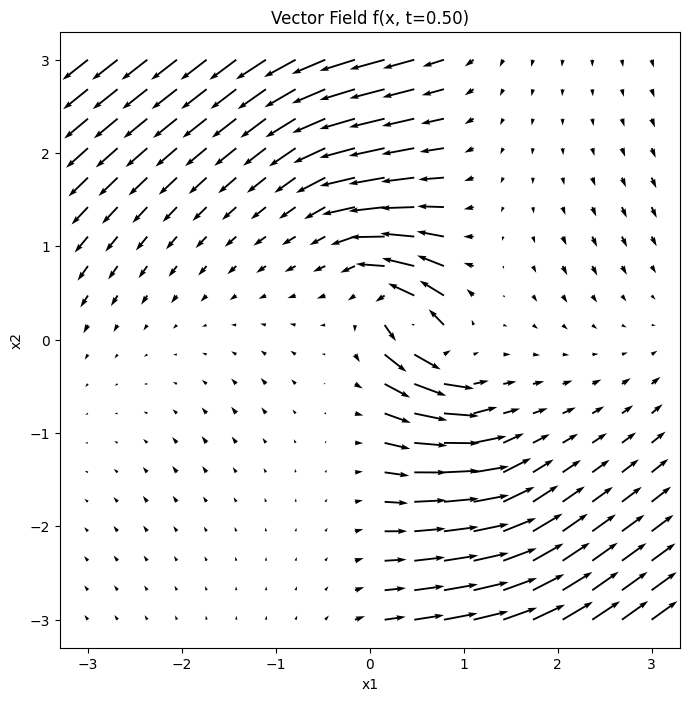

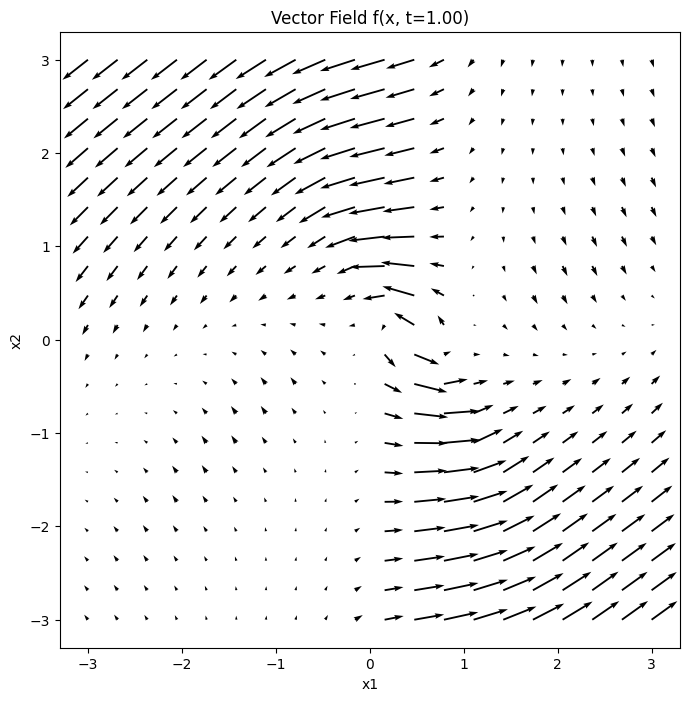

In [14]:
# Plot Vector Field
plot_vector_field(model, t=0.0, x_range=[-3, 3], y_range=[-3, 3])
plot_vector_field(model, t=0.5, x_range=[-3, 3], y_range=[-3, 3])
plot_vector_field(model, t=1.0, x_range=[-3, 3], y_range=[-3, 3])